In [10]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.model_selection import train_test_split
from skimage.transform import resize
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt


In [11]:
# Load the dataset
data = pd.read_csv(r'D:\Kuliah\Semester 6\Bangkit 2024\Capstone\nutrition.csv')

# Display the first few rows of the dataset
print(data.head())

# Check the dataset's info
print(data.info())

# Summary statistics
print(data.describe())

   id  calories  proteins   fat  carbohydrate                name  \
0   1     280.0       9.2  28.4           0.0                Abon   
1   2     513.0      23.7  37.0          21.3        Abon haruwan   
2   3       0.0       0.0   0.2           0.0           Agar-agar   
3   4      45.0       1.1   0.4          10.8  Akar tonjong segar   
4   5      37.0       4.4   0.5           3.8       Aletoge segar   

                                               image  
0  https://img-cdn.medkomtek.com/PbrY9X3ignQ8sVuj...  
1  https://img-global.cpcdn.com/recipes/cbf330fbd...  
2  https://res.cloudinary.com/dk0z4ums3/image/upl...  
3  https://images.tokopedia.net/img/cache/200-squ...  
4  https://nilaigizi.com/assets/images/produk/pro...  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1346 entries, 0 to 1345
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            1346 non-null   int64  
 1   calories      1

In [12]:
# Check for missing values
print(data.isnull().sum())

# Drop rows with missing values (if any)
data = data.dropna()

# Alternatively, you can fill missing values with the mean or median
# data.fillna(data.mean(), inplace=True)

id              0
calories        0
proteins        0
fat             0
carbohydrate    0
name            0
image           0
dtype: int64


In [13]:
# Normalize the nutritional data (calories, fat, protein, carbohydrate)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data[['calories', 'fat', 'proteins', 'carbohydrate']] = scaler.fit_transform(data[['calories', 'fat', 'proteins', 'carbohydrate']])


In [26]:
# Function to load and preprocess images from URLs
def load_and_preprocess_image_from_url(url):
    try:
        response = requests.get(url)
        img = Image.open(BytesIO(response.content))
        img = img.resize((224, 224))  # Resize images to 224x224
        img_array = np.array(img)
        img_array = img_array / 255.0  # Normalize pixel values to [0, 1]
        return img_array
    except Exception as e:
        print(f"Error processing image at URL {url}: {e}") #(Error Images : 166)
        return None


# Apply the function to the image paths in the dataset
data['image_data'] = data['image'].apply(load_and_preprocess_image_from_url)

Error processing image at URL https://katakabar.com/assets/images/upload/news/medium_news_1594438184.jpeg: cannot identify image file <_io.BytesIO object at 0x0000025F008E1D50>
Error processing image at URL https://png.pngtree.com/png-clipart/20220124/ourmid/pngtree-a-plate-of-delicious-fat-cow-free-elements-png-image_4252411.png: cannot identify image file <_io.BytesIO object at 0x0000025F5C07EFC0>
Error processing image at URL https://scontent.fcgk35-1.fna.fbcdn.net/v/t1.6435-9/121695429_676597869941401_1458702638921645964_n.jpg?_nc_cat=100&ccb=1-7&_nc_sid=a26aad&_nc_ohc=__IwAVKho7AAX9vwknv&_nc_ht=scontent.fcgk35-1.fna&oh=00_AfBzshz2zrHYSwZvSOBel1XuorFB4ySKktNdgOj7dB8Jng&oe=649DFFD5: cannot identify image file <_io.BytesIO object at 0x0000025F00744090>
Error processing image at URL https://www.piknikdong.com/wp-content/uploads/2021/04/Resep-Asinan-Sayur-Bogor-Sederhana.jpg: cannot identify image file <_io.BytesIO object at 0x0000025F5C105210>
Error processing image at URL https://e7.

In [27]:
# Define the column names for the labels
nutritional_columns = ['calories', 'fat', 'proteins', 'carbohydrate']  # Replace with actual column names

# Filter out rows where image_data is not of shape (224, 224)
filtered_data = data[data['image_data'].apply(lambda x: x is not None and x.shape == (224, 224))]

# Convert image data and labels to numpy arrays
X = np.array(filtered_data['image_data'].tolist())
y = filtered_data[nutritional_columns].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [28]:
# Define the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(4)  # Output layer for 4 nutritional values
])

# Resize images in X_train and X_test to (224, 224) and add channel dimension
X_train_resized = np.array([np.expand_dims(resize(img, (224, 224)), axis=-1) for img in X_train])
X_test_resized = np.array([np.expand_dims(resize(img, (224, 224)), axis=-1) for img in X_test])

# Reshape X_train_resized and X_test_resized to have the correct shape
X_train = X_train_resized.reshape(-1, 224, 224, 1)  # Assuming images are grayscale
X_test = X_test_resized.reshape(-1, 224, 224, 1)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=20, validation_split=0.2)

# Evaluate the model on the test set
test_loss, test_mae = model.evaluate(X_test, y_test)

print(f'Test MAE: {test_mae}')


Epoch 1/20


c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.5508 - mae: 0.6191 - val_loss: 65.7298 - val_mae: 7.5183
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - loss: 49.6186 - mae: 5.6584 - val_loss: 47.0406 - val_mae: 4.4753
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 23.6085 - mae: 2.9059 - val_loss: 29.0402 - val_mae: 5.0402
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - loss: 15.0368 - mae: 2.7335 - val_loss: 11.0389 - val_mae: 3.1861
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 5.2670 - mae: 1.5740 - val_loss: 3.7123 - val_mae: 1.7912
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 2.0224 - mae: 1.0289 - val_loss: 1.6401 - val_mae: 0.9768
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 1.3258 - mae: 0.8863 - val_loss: 1.0882 - val_mae: 0.6934
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 1.0345 - mae: 0.8899 - val_loss: 0.8058 - val_mae: 0.7059
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 0.7208 - mae: 0.7571 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.3826 - mae: 0.5675
Test MAE: 0.5675101280212402


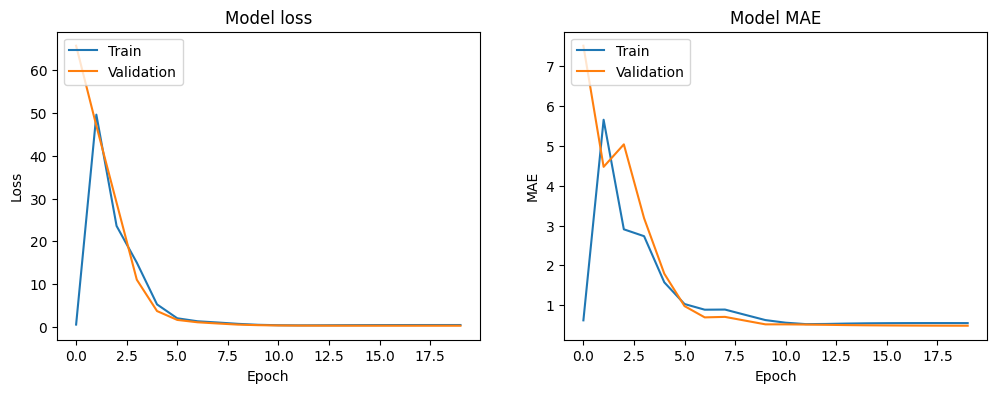

In [29]:
# Evaluate the model on the test set
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f'Test MAE: {test_mae}')

# Plot training & validation loss values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation MAE values
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


In [1]:
from tensorflow.keras.layers import Dropout

# Define the improved model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4)  # Output layer for 4 nutritional values
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Train the improved model
history = model.fit(X_train, y_train, epochs=20, validation_split=0.2)

# Evaluate the improved model on the test set
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f'Test MAE: {test_mae}')


NameError: name 'Sequential' is not defined

In [31]:
# Save the model
model.save('nutrition_model.h5')
